### This notebook contains recap of Prophet, LightGBM, and all other ensemble methods.

In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from prophet import Prophet
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import matplotlib.pyplot as plt
import math
#Bagging and Boosting libraries
from sklearn.ensemble import BaggingRegressor, AdaBoostRegressor
#from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.ensemble import BaggingRegressor
#Stacking:
from sklearn.ensemble import StackingRegressor,RandomForestRegressor
from sklearn.linear_model import LinearRegression
import time

In [2]:
df = pd.read_csv('C:/Users/Deepak/Desktop/Backup/Manuscript prep/sales_train_validation.csv')
#All category items are grouped together to create a target variable

df.drop(columns=['item_id', 'dept_id','store_id','state_id'],axis=1, inplace=True) 
data = df.T
data.columns = df['cat_id'] 
data.index.name = None   
data.drop(index='id',inplace=True) 
data.drop(index='cat_id',inplace=True) 
data.columns.name = None 
 
calendar = pd.read_csv('C:/Users/Deepak/Desktop/Backup/Manuscript prep/calendar.csv')
data.index = calendar['date'][0:1913]
df_cat = data.groupby(level=0, axis=1).sum()

#All department items are grouped together to create a target variable

df = pd.read_csv('C:/Users/Deepak/Desktop/Backup/Manuscript prep/sales_train_validation.csv')
df.drop(columns=['item_id', 'cat_id','store_id','state_id'],axis=1, inplace=True) 
data = df.T
data.columns = df['dept_id'] 
data.index.name = None   
data.drop(index='id',inplace=True) 
data.drop(index='dept_id',inplace=True) 
data.columns.name = None 

calendar = pd.read_csv('C:/Users/Deepak/Desktop/Backup/Manuscript prep/calendar.csv')
data.index = calendar['date'][0:1913]
df_dept = data.groupby(level=0, axis=1).sum()

#State-wise categorization
df = pd.read_csv('C:/Users/Deepak/Desktop/Backup/Manuscript prep/sales_train_validation.csv')
df.drop(columns=['item_id', 'dept_id','store_id','cat_id'],axis=1, inplace=True) 
data = df.T
data.columns = df['state_id'] 
data.index.name = None   
data.drop(index='id',inplace=True) 
data.drop(index='state_id',inplace=True) 
data.columns.name = None 
 
calendar = pd.read_csv('C:/Users/Deepak/Desktop/Backup/Manuscript prep/calendar.csv')
data.index = calendar['date'][0:1913]
df_state = data.groupby(level=0, axis=1).sum()

#Store-wise categorization
df = pd.read_csv('C:/Users/Deepak/Desktop/Backup/Manuscript prep/sales_train_validation.csv')
df.drop(columns=['item_id', 'dept_id','state_id','cat_id'],axis=1, inplace=True) 
data = df.T
data.columns = df['store_id'] 
data.index.name = None   
data.drop(index='id',inplace=True) 
data.drop(index='store_id',inplace=True) 
data.columns.name = None 
 
calendar = pd.read_csv('C:/Users/Deepak/Desktop/Backup/Manuscript prep/calendar.csv')
data.index = calendar['date'][0:1913]
df_store = data.groupby(level=0, axis=1).sum()
#Concat all dataframes
df = pd.concat([df_cat,df_dept,df_state,df_store, ], axis=1)
df.head(1)

,FOODS,HOBBIES,HOUSEHOLD,FOODS_1,FOODS_2,FOODS_3,HOBBIES_1,HOBBIES_2,HOUSEHOLD_1,HOUSEHOLD_2,...,CA_1,CA_2,CA_3,CA_4,TX_1,TX_2,TX_3,WI_1,WI_2,WI_3
date,,,,,,,,,,,,,,,,,,,,,
2011-01-29,23178,3764,5689,2343,4094,16741,3610,154,4105,1584,...,4337,3494,4739,1625,2556,3852,3030,2704,2256,4038


In [3]:
df['ds'] = df.index.values

# Convert the 'ds' column to datetime type
df['ds'] = pd.to_datetime(df['ds'])
#df.head()

In [4]:
# Split the data into train and test sets

train_size = int(len(df) * 0.8)  # 80% for training
train, test = df[:train_size], df[train_size+1:]

In [5]:
# train data has 2011-01-29 to 2015-04-07 (1530 rows) and test data has 2015-04-09 to 2016-04-24 (382 rows)
len(train),len(test)

(1530, 382)

In [6]:
target_columns = ['FOODS','HOBBIES','HOUSEHOLD','FOODS_1','FOODS_2','FOODS_3','HOBBIES_1','HOBBIES_2','HOUSEHOLD_1',
                  'HOUSEHOLD_2','CA','TX','WI','CA_1','CA_2','CA_3','CA_4','TX_1','TX_2','TX_3','WI_1','WI_2','WI_3']

In [7]:
# Fit Prophet models for each target variable
prophet_models = {}
for column in target_columns:
    # Rename the columns to 'ds' and 'y'
    train_target = train[[column]].rename(columns={column: 'y'})
    train_target['ds'] = train.index
    
    model = Prophet()
    model.fit(train_target)
    prophet_models[column] = model

12:59:43 - cmdstanpy - INFO - Chain [1] start processing
12:59:43 - cmdstanpy - INFO - Chain [1] done processing
12:59:43 - cmdstanpy - INFO - Chain [1] start processing
12:59:43 - cmdstanpy - INFO - Chain [1] done processing
12:59:44 - cmdstanpy - INFO - Chain [1] start processing
12:59:44 - cmdstanpy - INFO - Chain [1] done processing
12:59:44 - cmdstanpy - INFO - Chain [1] start processing
12:59:44 - cmdstanpy - INFO - Chain [1] done processing
12:59:44 - cmdstanpy - INFO - Chain [1] start processing
12:59:44 - cmdstanpy - INFO - Chain [1] done processing
12:59:45 - cmdstanpy - INFO - Chain [1] start processing
12:59:45 - cmdstanpy - INFO - Chain [1] done processing
12:59:45 - cmdstanpy - INFO - Chain [1] start processing
12:59:45 - cmdstanpy - INFO - Chain [1] done processing
12:59:45 - cmdstanpy - INFO - Chain [1] start processing
12:59:45 - cmdstanpy - INFO - Chain [1] done processing
12:59:46 - cmdstanpy - INFO - Chain [1] start processing
12:59:46 - cmdstanpy - INFO - Chain [1]

In [8]:
# Make predictions on the test set
predictions = {}
for column in target_columns:
    model = prophet_models[column]
    
    # Create future dataframe for predictions
    future = model.make_future_dataframe(periods=len(test))
    
    # Rename the columns to 'ds'
    future = future.rename(columns={'ds': 'ds'})
    
    # Make predictions
    #The .tail(len(test))` part ensures that only the predictions for the test set are stored.
    forecast = model.predict(future)
    predictions[column] = forecast['yhat'].tail(len(test))

In [9]:
# Calculate MAPE and RMSE for each target variable
mape = {}
rmse = {}
for column in target_columns:
    actual = test[column].values.astype('float64')
    predicted = predictions[column].values
    mape[column] = mean_absolute_percentage_error(actual, predicted)
    rmse[column] = np.sqrt(mean_squared_error(actual, predicted))

In [10]:
RMSE = []
MAPE = []

for column in target_columns:
    MAPE.append(mape[column])
    RMSE.append(rmse[column])

print("RMSE_Prophet:", RMSE)
print("MAPE_Prophet:", MAPE)

RMSE_Prophet: [5110.8235284834445, 558.8647341927426, 1585.081735746497, 595.9981400812075, 1191.0193788538754, 3876.7556364850784, 543.9021764641608, 160.33901493306325, 1303.2539654376048, 311.0364441083963, 3382.0284501647966, 1710.260102149567, 2485.5369066983744, 792.7791747591132, 2074.6689294284483, 903.3300883035496, 312.77741656797383, 531.7544317221473, 710.3019554751941, 556.4151381998163, 709.4270412204864, 1043.5941966349826, 1081.5826116893172]
MAPE_Prophet: [3.99210937291565, 3.9691575402403624e+16, 19.25785074713275, 7.404256954580688, 4.5102391159932344e+16, 2.8077851936001212, 3.392133001457955e+16, 5919047719780340.0, 6.847756335045825e+16, 4.0406680748275186, 5.201140553356924, 5.671856052364931, 6.053214668006202, 4.223807952361279e+16, 2.1972074429071773, 3.2130101947456073, 2.229458591990114e+16, 6.9712924887946, 3.3624949938388588e+16, 2.8330835813912802, 4.636563812586893, 9.528352523287227, 5.836580526735573]


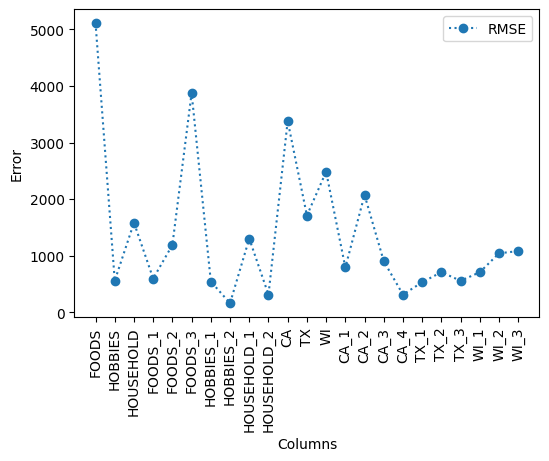

In [11]:
# Plot the RMSE values
plt.figure(figsize=(6,4))
plt.plot(target_columns, RMSE, marker='o', linestyle='dotted', label='RMSE')
plt.xticks(rotation=90)
plt.xlabel('Columns')
plt.ylabel('Error')
plt.legend()
plt.show()

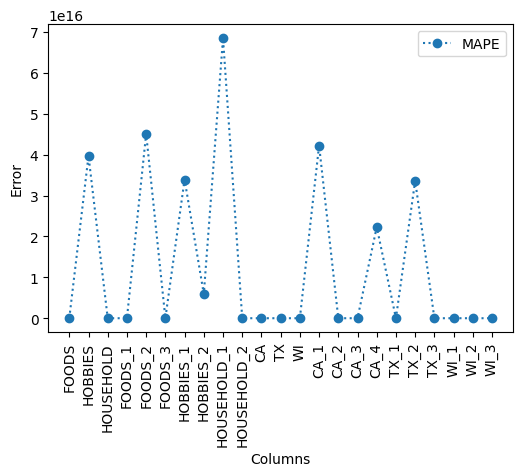

In [12]:
# Plot the MAPE values
plt.figure(figsize=(6, 4))
plt.plot(target_columns, MAPE, marker='o', linestyle='dotted', label='MAPE')
plt.xticks(rotation=90)
plt.xlabel('Columns')
plt.ylabel('Error')
plt.legend()
plt.show()

### XGBOOST

In [13]:
# The 'ds' column in the `train` and `test` DataFrames is converted from a datetime data type to a numerical representation.
#This is necessary because the XGBoost library does not support datetime columns by default.

train['ds'] = pd.to_numeric(train['ds'])
test['ds'] = pd.to_numeric(test['ds'])

C:\Users\Deepak\AppData\Local\Temp\ipykernel_6288\211572185.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['ds'] = pd.to_numeric(train['ds'])
C:\Users\Deepak\AppData\Local\Temp\ipykernel_6288\211572185.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ds'] = pd.to_numeric(test['ds'])


In [14]:
# Fit XGBoost models for each target variable.
'''This code iterates over each target column and fits an XGBoost regressor model to predict that column. 
The predictor variables are obtained by dropping the target column from the `train` DataFrame. 
The fitted models are stored in a dictionary called `models`, with the target column name as the key'''

models = {}

start_time = time.time()

for column in target_columns:
    X_train = train.drop(column, axis=1)
    y_train = train[column]
    
    model = xgb.XGBRegressor()
    model.fit(X_train, y_train)
    models[column] = model

# Make predictions on the test set
predictions = {}
for column in target_columns:
    model = models[column]
    X_test = test.drop(column, axis=1)
    
    y_pred = model.predict(X_test)
    predictions[column] = y_pred
    
execution_time = time.time() - start_time
print(f"Execution time: {execution_time} seconds")

Execution time: 4.68683123588562 seconds


In [15]:
RMSE = []
for column in target_columns:
    y_true = test[column]
    y_pred = predictions[column]
    
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    RMSE.append(rmse)

print("RMSE_XGBoost:", RMSE)

RMSE_XGBoost: [684.5201518781283, 58.32733658907493, 133.43926140001807, 432.27354609851494, 910.3908680489494, 506.78743602515453, 60.8622305373713, 96.89834073141365, 130.46233828315331, 144.22878194526086, 696.4173183222433, 264.2913221138851, 344.33383229528016, 380.4926819621933, 1276.8889879924964, 432.8312179600542, 161.1345705527386, 161.4462891527314, 186.5938990504928, 292.93124724825554, 356.38277625452577, 426.3690554448898, 277.1735669399432]


### Bagging

In [16]:
# Fit BaggingRegressor models for each target variable
models = {}

start_time = time.time()
for column in target_columns:
    X_train = train.drop(column, axis=1)
    y_train = train[column]
    
    model = BaggingRegressor(base_estimator=xgb.XGBRegressor(), n_estimators=10)
    model.fit(X_train, y_train)
    models[column] = model

# Make predictions on the test set
predictions = {}
for column in target_columns:
    model = models[column]
    X_test = test.drop(column, axis=1)
    
    y_pred = model.predict(X_test)
    predictions[column] = y_pred

    execution_time = time.time() - start_time
print(f"Execution time: {execution_time} seconds")

C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `e

Execution time: 28.942972660064697 seconds


In [17]:
RMSE = []
for column in target_columns:
    y_true = test[column]
    y_pred = predictions[column]
    
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    RMSE.append(rmse)

print("RMSE_Bagging:", RMSE)

RMSE_Bagging: [635.7309905339839, 51.21077747302048, 170.38306726231986, 363.9824370841094, 941.9781039582339, 475.9669749572799, 50.14146256685801, 98.57382971553204, 158.57545465975792, 136.61513884584866, 747.670936228116, 247.17672194280263, 379.17049618613675, 406.754391485305, 1297.7136744262657, 427.18345900601423, 162.22679994912744, 162.05898429508778, 162.5693801376388, 222.6273719288888, 310.34717813864387, 440.1111660289403, 278.0577131183845]


### Stacking

In [18]:
# Fit StackingRegressor models for each target variable
stacking_models = {}

start_time = time.time()
for column in target_columns:
    X_train = train.drop(column, axis=1)
    y_train = train[column]
    
    estimators = [
        ('xgb', xgb.XGBRegressor()),
        ('bagging', BaggingRegressor(base_estimator=xgb.XGBRegressor(), n_estimators=10))
    ]
    
    model = StackingRegressor(estimators=estimators, final_estimator=LinearRegression())
    model.fit(X_train, y_train)
    
    stacking_models[column] = model
    
execution_time = time.time() - start_time
print(f"Execution time: {execution_time} seconds")

C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `e

C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `e

C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `e

C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `e

Execution time: 199.82520461082458 seconds


In [19]:
# Make predictions on the test set using the stacking models
stacking_predictions = {}
for column in target_columns:
    model = stacking_models[column]
    X_test = test.drop(column, axis=1)
    
    y_pred = model.predict(X_test)
    stacking_predictions[column] = y_pred

In [20]:
# Calculate the RMSE for each target column
stacking_RMSE = []
for column in target_columns:
    y_true = test[column]
    y_pred = stacking_predictions[column]
    
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    stacking_RMSE.append(rmse)

print("RMSE_Stacking:", stacking_RMSE)

RMSE_Stacking: [598.5503462251221, 58.45868972430319, 126.76677811374435, 337.1799242104262, 957.0343868077767, 510.3623382647685, 57.812712593784866, 108.62702993636563, 128.94998023490712, 143.61200475561154, 674.9352832838113, 260.4631330241754, 327.06754349073225, 423.80239312038077, 1275.681040178437, 441.0982520269786, 162.47797710346342, 168.31409652416045, 167.8711019716187, 288.9329101653612, 455.0074672117945, 432.9969971875841, 237.8830103914325]


### Stacking using meta-learners (Random Forest Regressor)

In [21]:
# Fit StackingRegressor models for each target variable
stacking_models = {}

start_time = time.time()
for column in target_columns:
    X_train = train.drop(column, axis=1)
    y_train = train[column]
    
    estimators = [
        ('xgb', xgb.XGBRegressor()),
        ('bagging', BaggingRegressor(base_estimator=xgb.XGBRegressor(), n_estimators=10))
    ]
    
    meta_learner = RandomForestRegressor()  # Meta-learner model, can be any regression model
    
    stacking_model = StackingRegressor(estimators=estimators, final_estimator=meta_learner)
    stacking_model.fit(X_train, y_train)
    
    stacking_models[column] = stacking_model
    
execution_time = time.time() - start_time
print(f"Execution time: {execution_time} seconds")

C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `e

C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `e

C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `e

C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `e

Execution time: 207.1814682483673 seconds


In [22]:
# Make predictions on the test set using the stacking models
stacking_predictions = {}
for column in target_columns:
    stacking_model = stacking_models[column]
    X_test = test.drop(column, axis=1)
    
    y_pred = stacking_model.predict(X_test)
    stacking_predictions[column] = y_pred

In [23]:
# Calculate the RMSE for each target column
stacking_meta_learner_RMSE = []
for column in target_columns:
    y_true = test[column]
    y_pred = stacking_predictions[column]
    
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    stacking_meta_learner_RMSE.append(rmse)

print("RMSE_Stacking for Random Forest Regressor:", stacking_meta_learner_RMSE)

RMSE_Stacking for Random Forest Regressor: [635.1593056307366, 63.8604103510886, 250.48710416848226, 447.91123608945475, 968.8330756912686, 534.3130513546397, 71.22838982651149, 277.61544251495604, 201.86996790674473, 179.14544835695858, 634.3032128899087, 263.14736622230936, 472.70933924414766, 481.12407060192425, 1240.9920562392624, 505.68933575241357, 184.17658638095781, 184.77336254738688, 192.92107002185367, 308.17685395246974, 615.8807171777349, 430.70473819687146, 300.3559111327027]


### FORECAST Plot with Stacking (Random Forest regressor)

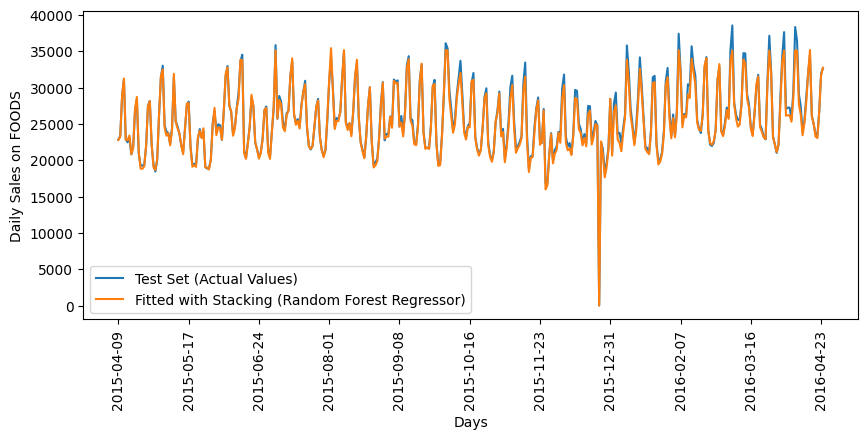

In [53]:
y_true = test['FOODS']
y_pred = stacking_predictions['FOODS']

plt.figure(figsize=(10, 4))
plt.plot(y_true.index, y_true, label='Test Set (Actual Values)')
plt.plot(y_true.index, y_pred, label='Fitted with Stacking (Random Forest Regressor)')
plt.xlabel('Days')
plt.ylabel('Daily Sales on FOODS')
plt.legend()

# Set the step size for x-axis ticks
step = int(len(y_true.index) / 10)  # Adjust the step size as per your preference

plt.xticks(np.arange(0, len(y_true.index), step), rotation=90)
plt.show()

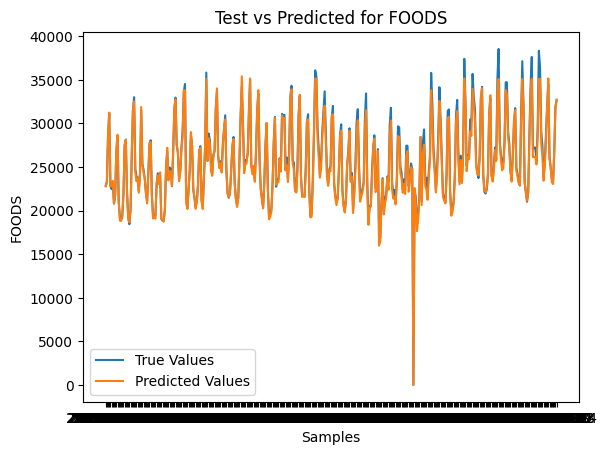

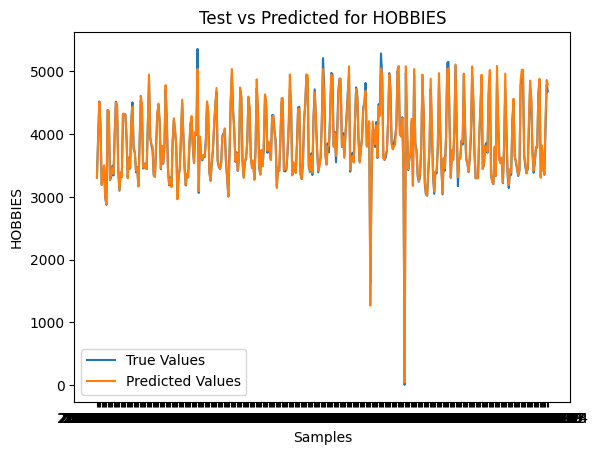

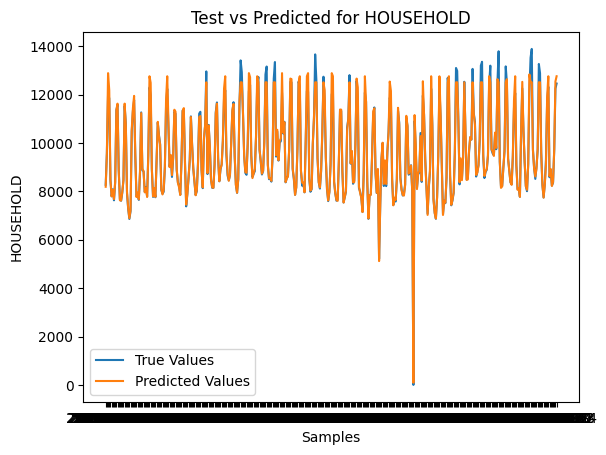

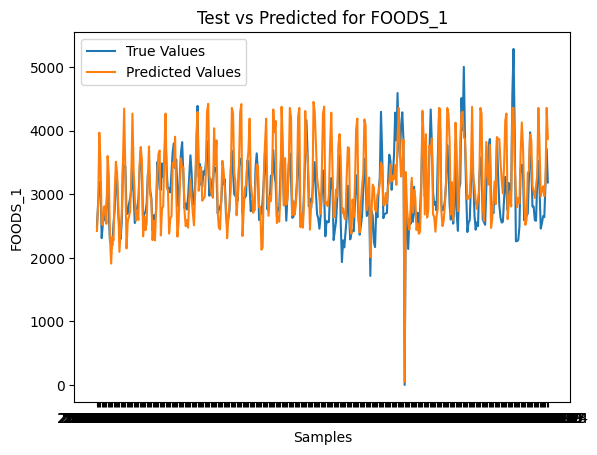

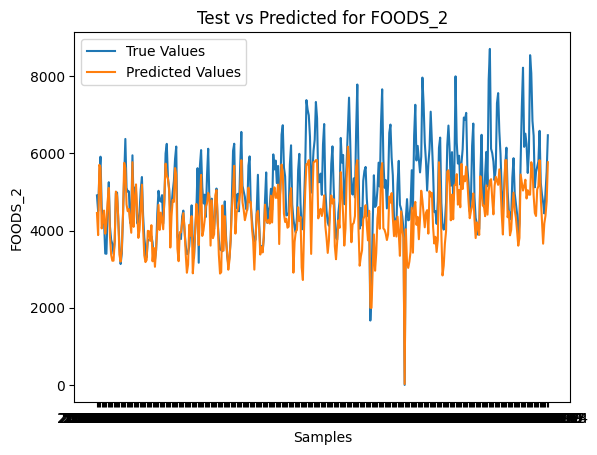

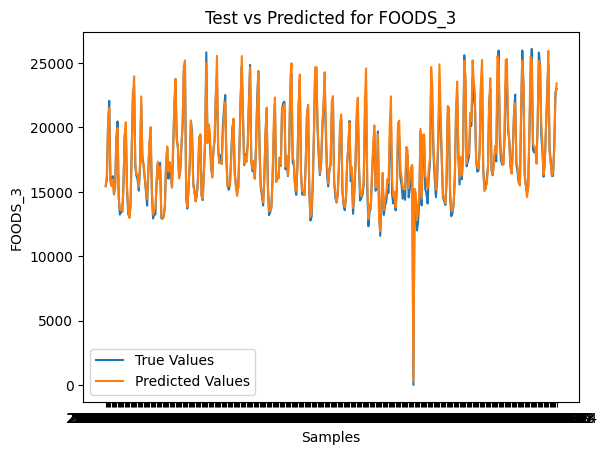

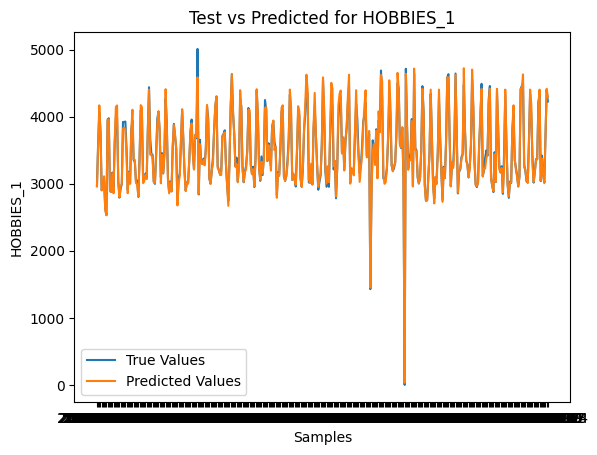

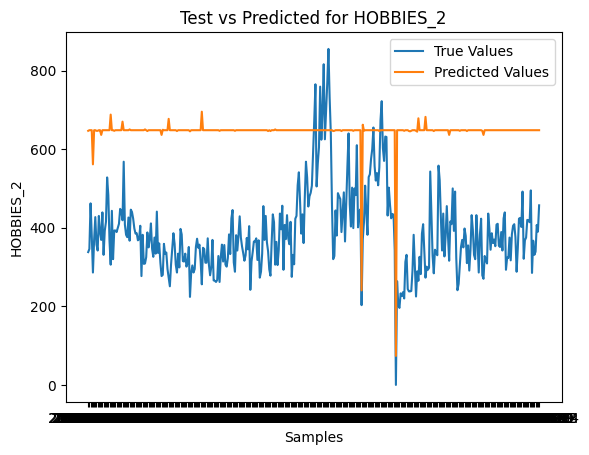

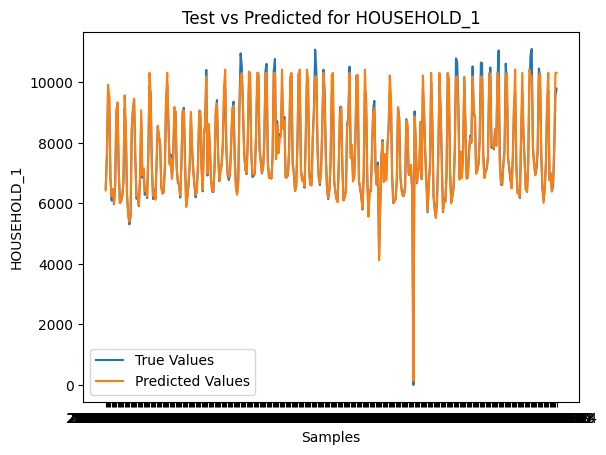

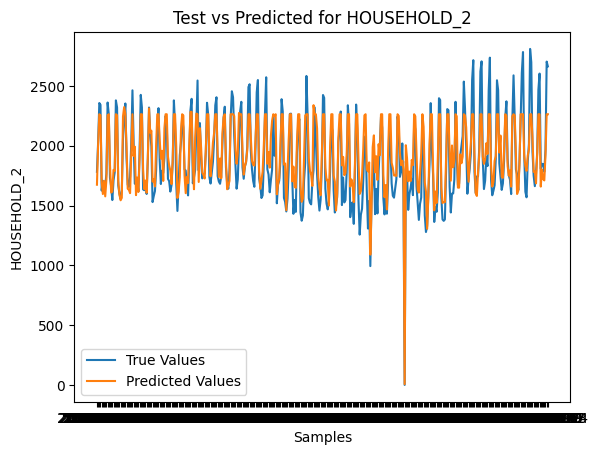

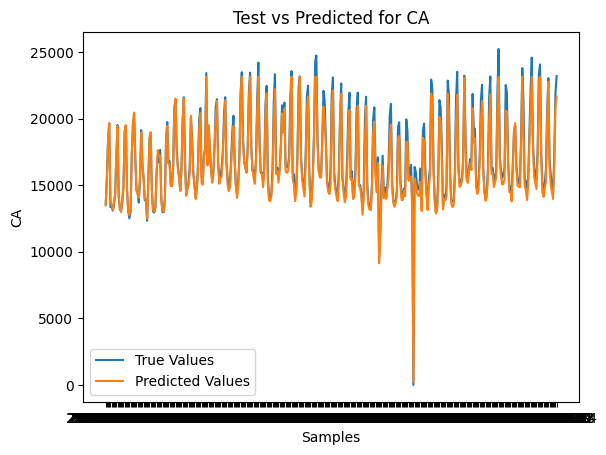

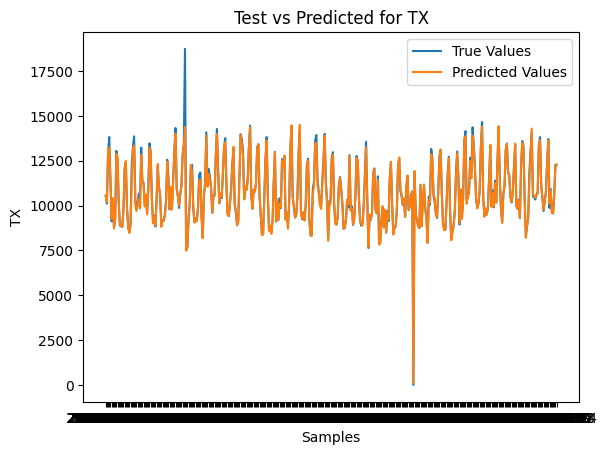

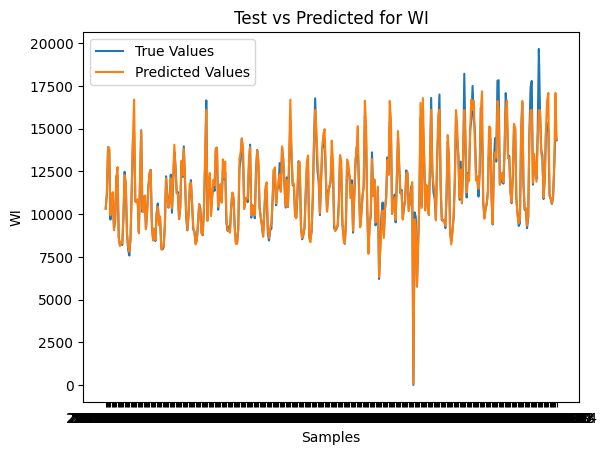

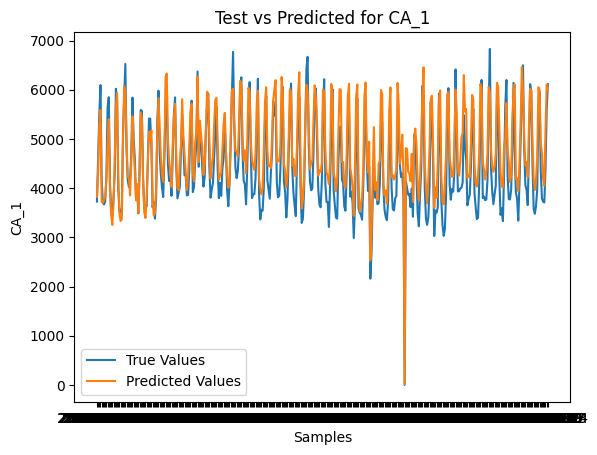

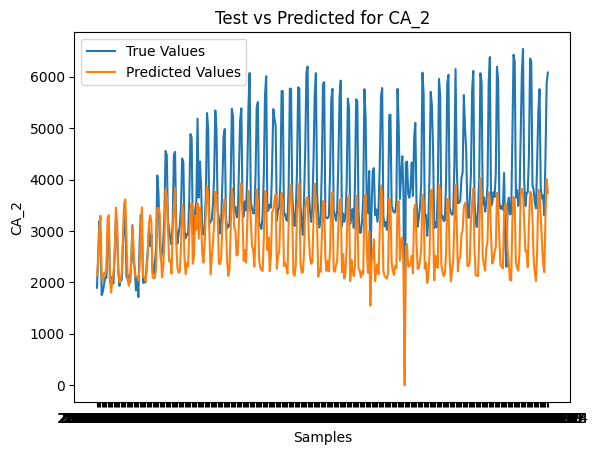

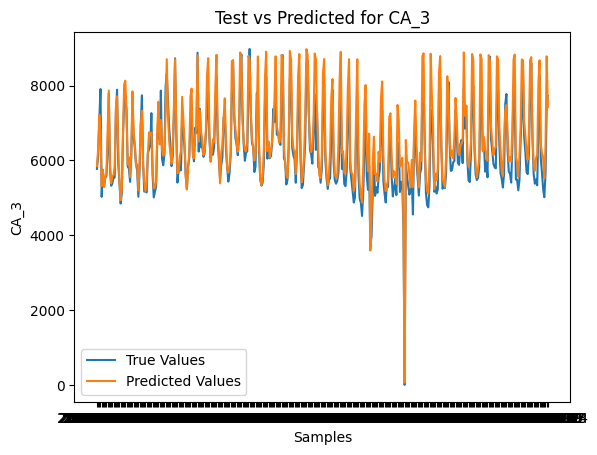

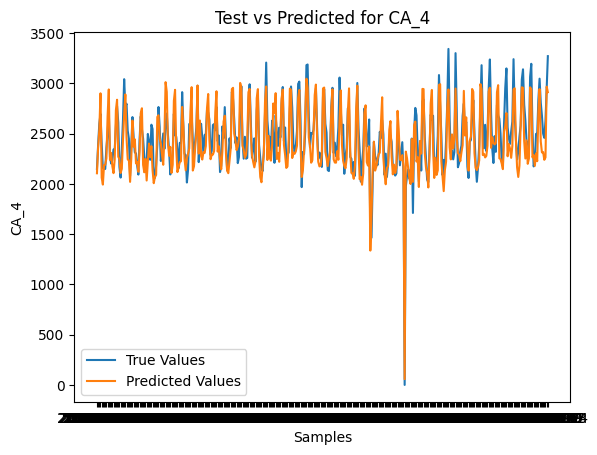

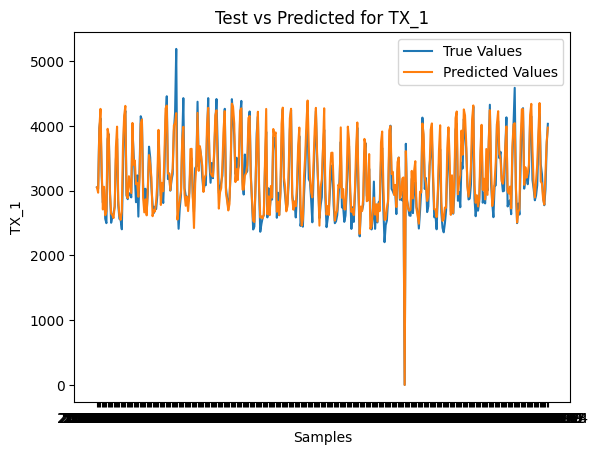

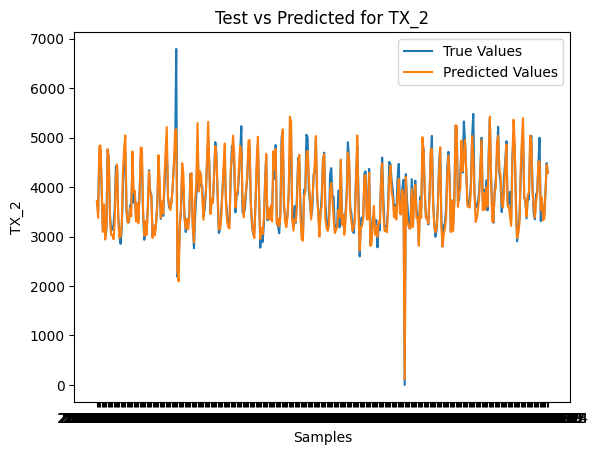

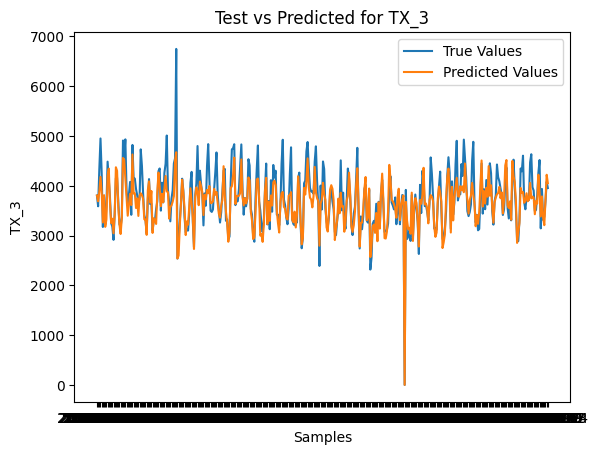

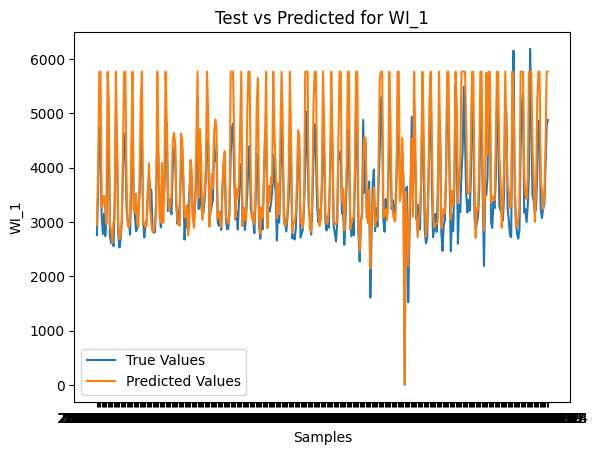

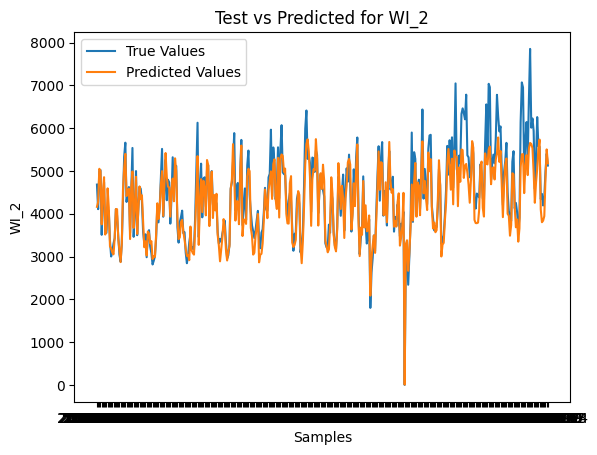

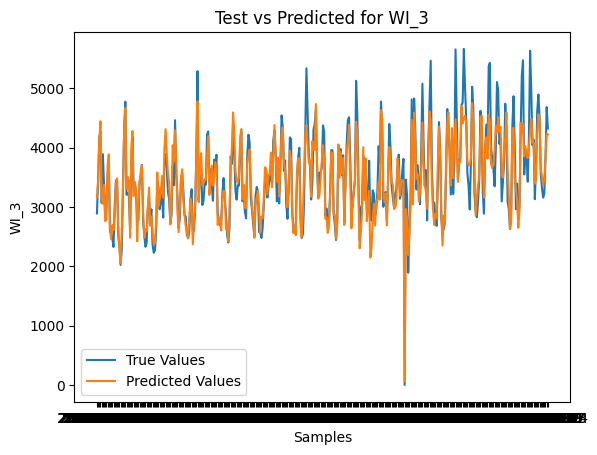

In [25]:
# Plotting test dataset and predicted dataset
for column in target_columns:
    y_true = test[column]
    y_pred = stacking_predictions[column]
    
    plt.figure()
    plt.plot(y_true.index, y_true, label='True Values')
    plt.plot(y_true.index, y_pred, label='Predicted Values')
    plt.xlabel('Samples')
    plt.ylabel(column)
    plt.legend()
    plt.title(f'Test vs Predicted for {column}')
    plt.show()

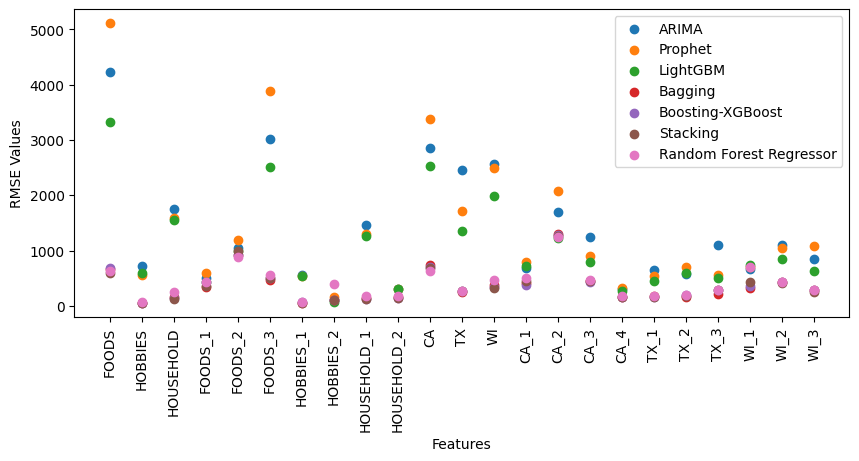

In [46]:
target_cols = ['FOODS','HOBBIES','HOUSEHOLD','FOODS_1','FOODS_2','FOODS_3','HOBBIES_1','HOBBIES_2','HOUSEHOLD_1',
               'HOUSEHOLD_2','CA', 'TX','WI','CA_1','CA_2', 'CA_3','CA_4', 'TX_1', 'TX_2', 'TX_3','WI_1','WI_2', 'WI_3']  

ARIMA = [4236.316723918323, 722.9587804912617, 1744.563933804136, 501.8643498636273, 1052.8060754643564, 3019.485625175322, 564.1090882968341, 107.71514370490577, 1457.2227059488523, 311.7684220978746, 2845.070878093155, 2452.900482994489, 2568.1895181351188, 675.2928099681411, 1690.6794693220677, 1252.527860456889, 306.3509659901929, 641.2702711133608, 567.048465141332, 1095.8547022419095, 667.7591649917505, 1094.4614910282958, 853.7038135087865] 

Prophet =  [5110.8235284834445, 558.8647341927426, 1585.081735746497, 595.9981400812075, 1191.0193788538754, 3876.755636485078, 
            543.9021764641608, 160.33901493306325, 1303.2539654376048, 311.0364441083963, 3382.0284501647966, 
            1710.260102149567, 2485.536906698374, 792.7791747591133, 2074.6689294284483, 903.3300883035496, 
            312.77741656797383, 531.7544317221472, 710.301955475194, 556.4151381998163, 709.4270412204864, 
            1043.5941966349826, 1081.5826116893172]

LightGBM = [3319.590534537011,584.3977140491161, 1556.3873564216303, 433.0666251027355, 983.883585620006, 2503.339659573278,
            546.1107184801933,74.0229975877067,1270.1774091024874,304.5712510724757, 2522.012126488803, 1344.2516137774141,
            1986.7149140411043,710.8527467603836, 1227.410039106039, 794.9171988255989, 267.32320301143085, 451.72115419990445,
            595.0289127363693, 507.97801283937685,741.5630069409465, 843.1657277152618, 631.853972936856]

XGBoost = [684.5201518781283, 58.32733658907493, 133.43926140001807, 432.27354609851494, 910.3908680489494, 
                506.78743602515453, 60.8622305373713, 96.89834073141365, 130.46233828315331, 144.22878194526086, 
                696.4173183222433, 264.2913221138851, 344.33383229528016, 380.4926819621933, 1276.8889879924964, 
                432.8312179600542, 161.1345705527386, 161.4462891527314, 186.5938990504928, 292.93124724825554, 
                356.38277625452577, 426.3690554448898, 277.1735669399432]

Bagging = [658.8102849331476, 55.433439682131464, 165.97897202010964, 345.8699716991141, 925.228487183954, 
               474.80221120287734, 46.46854076152143, 97.82103218555623, 138.6758167808733, 151.39792802276364, 
               743.6384751084347, 256.08298820570775, 373.1195584400961, 420.3021208629403, 1301.432930106316, 
               439.63596372481373, 166.91434936063823, 174.79945210450302, 160.41951450339675, 219.86665617502976, 
               322.13404994399076, 432.28334927148603, 288.37137697853217]

Stacking = [595.507174429319, 56.409265688546775, 126.94033565664685, 356.86626415714414, 983.7996527412449, 
            495.4830393432965, 56.92251452223829, 105.8728796852712, 123.2754222116051, 146.009488626472, 
            680.6572166263741, 262.64642932613253, 327.08592544028795, 442.31215840655796, 1270.2362588853962, 
            445.0209901599056, 162.5979809497748, 166.9886968461545, 184.1980911654955, 286.4085760611746, 
            424.9553886337423, 413.9047181932017, 256.70817059808843]

RF_Regressor =[627.3532723343671, 61.758482773645106, 256.54148181815646, 421.76245512229434, 887.717741046583, 
               560.510961326841, 69.18899978770494, 387.0589292079194, 177.06062308463845, 176.5113281274883, 
               626.5962857347598, 267.07718729822454, 466.43248809952337, 499.7887126505879, 1251.5735015651926,
               468.17863408323313, 178.55342397396703, 183.4916998836133, 190.46807963939344, 283.59175479359584, 
               697.8609639063076, 438.7109411023754, 277.8611247326555]

plt.figure(figsize=(10, 4))
plt.scatter(target_cols, ARIMA, marker='o', label="ARIMA")
plt.scatter(target_cols, Prophet, marker='o', label="Prophet")
plt.scatter(target_cols, LightGBM, marker='o', label="LightGBM")
plt.scatter(target_cols, Bagging, marker='o', label="Bagging")
plt.scatter(target_cols, XGBoost, marker='o', label="Boosting-XGBoost")
plt.scatter(target_cols, Stacking, marker='o', label="Stacking")
plt.scatter(target_cols, RF_Regressor, marker='o', label="Random Forest Regressor")
plt.xlabel("Features")
plt.ylabel("RMSE Values")
plt.legend()
plt.xticks(rotation=90)
plt.show()

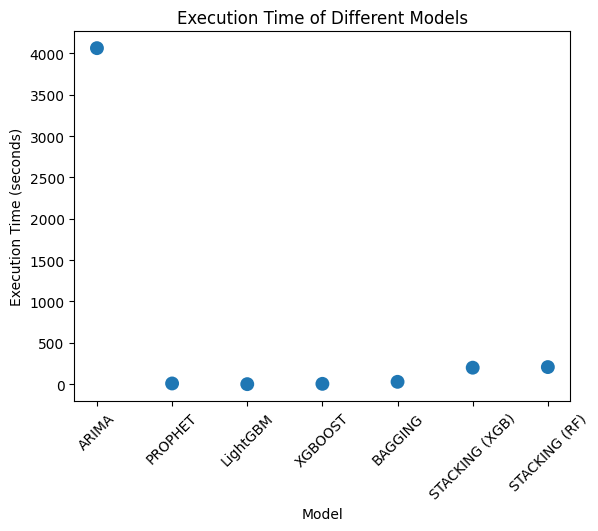

In [9]:
# Execution time plots

model = ['ARIMA', 'PROPHET','LightGBM','XGBOOST','BAGGING','STACKING (XGB)', 'STACKING (RF)' ]
execution_time = [4062.0541095733643,9.051079511642456, 0.866776704788208,4.68683123588562, 28.942972660064697, 199.82520461082458,207.1814682483673]

plt.scatter(model, execution_time, s=100, marker='o', edgecolors='none')
plt.xlabel('Model')
plt.ylabel('Execution Time (seconds)')
plt.title('Execution Time of Different Models')

plt.xticks(rotation=45)  # Rotate the Y-axis labels by 45 degrees

plt.show()